## QuantGAN made Conditional

Findings

- 30 day historical conditions was bad
- 252 day was better, captured tails better (heavy to run)
- Testing 3 condtions: kurtosis, cum return and volatility


In [1]:
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm
import random

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

In [2]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:75]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [3]:
returns = returns_df['REEL'].values
test_returns = test_returns_df['REEL'].values

In [4]:
returns_mean = np.mean(returns)
returns_norm = returns - returns_mean

## Preprocessing

In [5]:
def delta_init(z):
    k = kurtosis(z, fisher=False, bias=False)
    if k < 166. / 62.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)

def delta_gmm(z):
    delta = delta_init(z)
    
    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k
    
    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def W_delta(z, delta):
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)

def W_params(z, params):
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

def inverse(z, params):
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps=1e-6, max_iter=100):
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)
        
        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            break
        if k == max_iter - 1:
            raise RuntimeError("Solution not found")
            
    return params

In [6]:
params = igmm(returns_norm)
processed_returns = W_delta((returns_norm - params[0]) / params[1], params[2])
returns_max = np.max(np.abs(processed_returns))
processed_returns /= returns_max

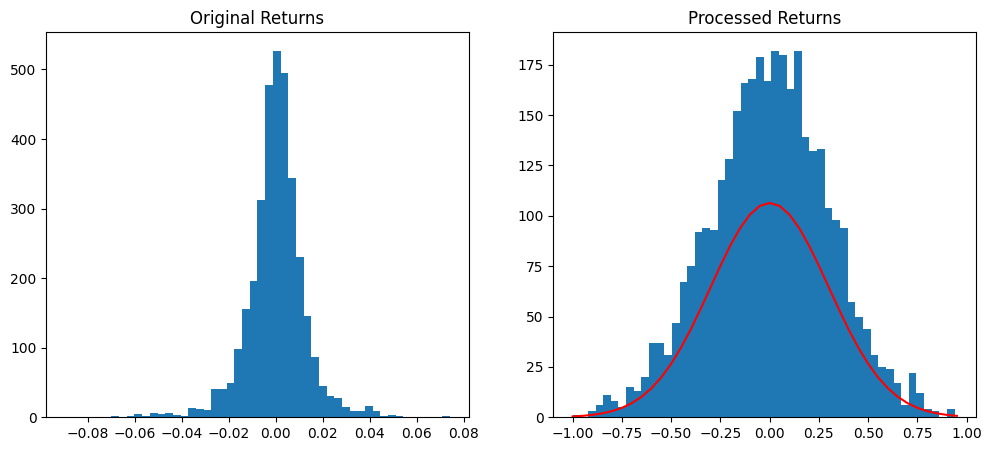

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(returns, bins=50)
plt.title('Original Returns')
plt.subplot(1,2,2)
plt.hist(processed_returns, bins=50)
x_axis = np.arange(-1, 1, 0.05)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.3) * 80, color='r')
plt.title('Processed Returns')
plt.show()

### Making Conditions

In [8]:
from scipy.stats import kurtosis
from sklearn.decomposition import PCA

windows    = []
total_windows = len(processed_returns) - 252

for i in range(total_windows):
    window = processed_returns[i : i + 252]
    windows.append(window)

windows = np.stack(windows)       # shape: (batch, 252)

### NOTE

Need to possibly create conditions from untransformed returns for when i test

In [9]:
conditions = []

for i in range(len(windows)):
    window = processed_returns[i : i + 252]
    k   = kurtosis(window, fisher=True, bias=False)     
    vol = window.std(ddof=1)                             
    cr  = np.prod(1 + window) - 1
    last_return = window[-1]        

    cond = np.array([k, vol, cr, last_return], dtype=np.float32)
    conditions.append(cond)

conditions = np.stack(conditions) 

In [10]:
conditions

array([[ 0.6485059 ,  0.24867338, -0.7505702 ,  0.11411317],
       [ 0.65049094,  0.24863368, -0.7672514 ,  0.0254284 ],
       [ 0.66353387,  0.24841428, -0.72201574,  0.0309437 ],
       ...,
       [-0.4304311 ,  0.2117299 , -0.50083673,  0.09260381],
       [-0.43724024,  0.21227446, -0.4608763 ,  0.3585082 ],
       [-0.43856502,  0.21232942, -0.63211465, -0.17892852]],
      shape=(3187, 4), dtype=float32)

In [11]:
'''
total_windows = len(processed_returns) - 252
windows = []
conditions = []

for i in range(total_windows):
    current_window = processed_returns[i:i+252]
    windows.append(current_window)
    condition_length = 252  
    condition = current_window[-condition_length:]
    conditions.append(condition)
'''

windows_real = []
for i in range(total_windows):
    current_window = returns[i:i+252]
    windows_real.append(current_window)

In [12]:
class ConditionalReturnsDataset(Dataset):
    def __init__(self, returns_data, conditions_data, window_size=252):

        self.returns_data    = returns_data[:, :, None]  
        self.conditions_data = conditions_data[:, None, :]  
        
    def __getitem__(self, index):
        x     = self.returns_data[index]    
        cond  = self.conditions_data[index] 
        return torch.from_numpy(x).float(), torch.from_numpy(cond).float()
    
    def __len__(self):
        return len(self.returns_data)


In [13]:
# Dataset class
class ReturnsDataset(Dataset):
    def __init__(self, data, window=252):
        self.data = data
        self.window = window
        
    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()
    
    def __len__(self):
        return len(self.data) - self.window

## Model Archtecture

In [14]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()
        
        self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        
        self.init_weights()
        
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)
            
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res


class TCN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TCN, self).__init__()
        layers = []
        dilation = 1
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()
        
    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)


class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TCN(input_size, output_size)
        
    def forward(self, x):
        return torch.tanh(self.net(x))


class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TCN(input_size, output_size)
        
    def forward(self, x):
        return torch.sigmoid(self.net(x))

In [15]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_size, condition_size, output_size, n_hidden=80):
        super().__init__()
        self.noise_encoder     = TCN(noise_size, n_hidden)
        self.condition_encoder = nn.GRU(condition_size, n_hidden, batch_first=True)
        # new “merge” layer
        self.merge             = nn.Linear(2 * n_hidden, n_hidden)
        self.tcn_output        = TCN(n_hidden, output_size)

    def forward(self, noise, condition):
        # noise_encoded: (B, seq_len, n_hidden)
        noise_encoded = self.noise_encoder(noise)

        # condition_encoded: (B, 1, n_hidden) → expand to (B, seq_len, n_hidden)
        _, h_n = self.condition_encoder(condition)
        cond_enc = h_n.permute(1, 0, 2)
        cond_enc = cond_enc.expand(-1, noise.size(1), -1)

        # **concat** along feature‐axis → (B, seq_len, 2*n_hidden)
        x = torch.cat([noise_encoded, cond_enc], dim=-1)
        # project back to n_hidden
        x = F.relu(self.merge(x))

        return torch.tanh(self.tcn_output(x))
    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_size, condition_size, output_size, n_hidden=80):
        super(ConditionalDiscriminator, self).__init__()
        # Process the time series
        self.tcn = TCN(input_size, n_hidden)
        
        # Process the condition
        self.condition_encoder = nn.GRU(condition_size, n_hidden, batch_first=True)
        
        # Final classification layer now takes concatenated features
        self.output_layer = nn.Linear(2 * n_hidden, output_size)
        
    def forward(self, x, condition):
        # x: [batch, seq_len, input_size]
        features = self.tcn(x)                            # → [batch, seq_len, n_hidden]
        last_features = features[:, -1, :]               # → [batch, n_hidden]
        
        # condition: [batch, seq_len_c=1, condition_size]
        _, h_n = self.condition_encoder(condition)        # h_n: [1, batch, n_hidden]
        cond_feats = h_n.squeeze(0)                       # → [batch, n_hidden]
        
        # Concatenate along feature dimension
        combined = torch.cat([last_features, cond_feats], dim=1)  # → [batch, 2*n_hidden]
        
        # Output probability
        return torch.sigmoid(self.output_layer(combined))


In [16]:
def condition_consistency_loss(generator, z, conditions):
    original_samples = generator(z, conditions)
    
    # Shuffle the conditions between examples
    shuffled_idx = torch.randperm(conditions.size(0))
    shuffled_conditions = conditions[shuffled_idx]
    
    # Generate with shuffled conditions
    shuffled_samples = generator(z, shuffled_conditions)
    
    # These should be different - maximize L1 distance
    # We negate because we want to maximize difference
    return -torch.mean(torch.abs(original_samples - shuffled_samples))

In [ ]:
# Training parameters
clip_value = 0.01
lr = 0.0002
num_epochs = 10
nz = 3  # Noise dimension
condition_size = 4  # Dimension of each element in your condition (typically 1 for return values)
batch_size = 30 #30
seq_len = 252  # 252 trading days in a year

netG = ConditionalGenerator(
    noise_size=nz, 
    condition_size=condition_size, 
    output_size=1, 
    n_hidden=80
).to(device)

netD = ConditionalDiscriminator(
    input_size=1, 
    condition_size=condition_size, 
    output_size=1, 
    n_hidden=80
).to(device)

optD = optim.RMSprop(netD.parameters(), lr=lr)
optG = optim.RMSprop(netG.parameters(), lr=lr)


dataset = ConditionalReturnsDataset(windows, conditions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

t = tqdm(range(num_epochs))
for epoch in t:
    for i, (data, condition) in enumerate(dataloader):
        real = data.to(device)
        condition = condition.to(device)
       
        batch_size, seq_len = real.size(0), real.size(1)
        
        netD.zero_grad()
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = netG(noise, condition).detach()
        
        lossD = -torch.mean(netD(real, condition)) + torch.mean(netD(fake, condition))
        lossD.backward()
        optD.step()
        
        # Clip weights
        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)
        
        
        if i % 5 == 0:
            netG.zero_grad()
            
            noise_1 = torch.randn(batch_size, seq_len, nz, device=device)
            noise_2 = torch.randn(batch_size, seq_len, nz, device=device)
            
            fake_outputs_1 = netG(noise_1, condition)
            fake_outputs_2 = netG(noise_2, condition)
            
            lossG = -torch.mean(netD(fake_outputs_1, condition))
            
            output_distance = torch.mean(torch.abs(fake_outputs_1 - fake_outputs_2))
            
            noise_distance = torch.mean(torch.abs(noise_1 - noise_2))
            
            # From this paper: https://arxiv.org/pdf/1903.05628. Does not work
            mode_seeking_loss = -torch.div(output_distance, noise_distance + 1e-5)
            
            # Implemented consistency_loss --> same noise, different condidtions --> should produce different windows
            if batch_size > 1:  
                idx = torch.randperm(batch_size)
                shuffled_condition = condition[idx]
                
                shuffled_outputs = netG(noise_1, shuffled_condition)
                
                consistency_loss = -torch.mean(torch.abs(fake_outputs_1 - shuffled_outputs))
                
                lambda_consistency = 0
                lambda_mode_seeking = 0.0  # Adjust this weight as needed
                
                lossG = lossG + lambda_consistency * consistency_loss + lambda_mode_seeking * mode_seeking_loss
            else:
                lossG = lossG + lambda_mode_seeking * mode_seeking_loss
                
            lossG.backward()
            optG.step()    
    
    # Report metrics
    t.set_description('Loss_D: %.8f Loss_G: %.8f Mode-Seeking: %.8f' % 
                      (lossD.item(), lossG.item(), mode_seeking_loss.item()))
    


  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\nicka\master-thesis\packages\Lib\site-packages\torch\nn\modules\conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(
Loss_D: -0.00000077 Loss_G: -0.49756086 Mode-Seeking: -0.00001199:  60%|██████    | 6/10 [03:17<02:10, 32.67s/it]

In [ ]:
def generate_scenarios_from_random_conditions_2(
    netG,
    n_scenarios=1000,
    window_size=252,
    nz=3,
):
    scenarios = []
    t = tqdm(range(n_scenarios))
    for _ in t:
        cond_vec = conditions[np.random.randint(len(conditions))]  
        condition = (
            torch.from_numpy(cond_vec)
                .view(1, 1, 4)           # batch=1, seq_len=1, features=5
                .to(device)
        )
        noise = torch.randn(1, window_size, nz, device=device)
        with torch.no_grad():
            gen = netG(noise, condition).cpu().numpy()
        gen = gen[0, :, 0] 
        denorm = gen * returns_max
        original = inverse(denorm, params) + returns_mean

        scenarios.append(original)

    return np.stack(scenarios)


## Checking if the model interprets condtions or ignores

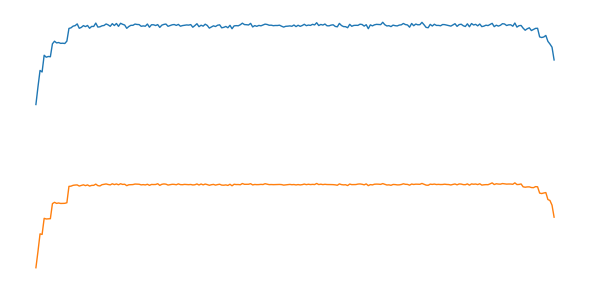

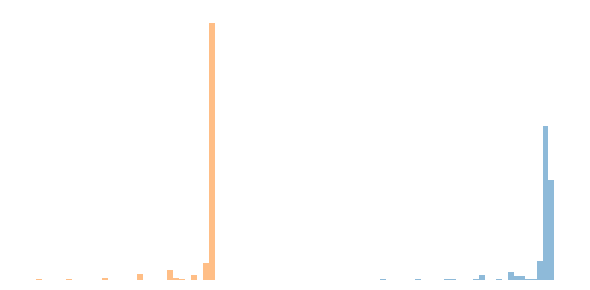

In [ ]:
fixed_noise = torch.randn(1, seq_len, nz, device=device)
c1 = torch.zeros(1,1,4, device=device)
c2 = torch.ones (1,1,4, device=device) * 100000
out1 = netG(fixed_noise, c1).cpu().detach().numpy().squeeze()
out2 = netG(fixed_noise, c2).cpu().detach().numpy().squeeze()
plt.figure(figsize=(6,3))
plt.plot(out1, linewidth=1)
plt.plot(out2, linewidth=1)
plt.axis('off')       
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 3))
plt.hist(out1, bins=30, alpha=0.5)
plt.hist(out2, bins=30, alpha=0.5)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
c1, c2

(tensor([[[0., 0., 0., 0.]]]),
 tensor([[[100000., 100000., 100000., 100000.]]]))

100%|██████████| 4000/4000 [00:34<00:00, 115.91it/s]


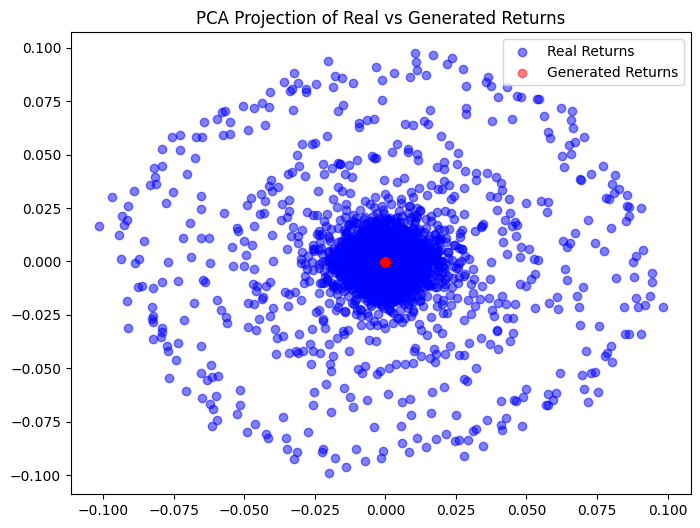

In [ ]:
from sklearn.decomposition import PCA

real_returns, generated_returns = np.array(windows_real), generate_scenarios_from_random_conditions_2(netG, n_scenarios=4000)
pca = PCA(n_components=2)
real_pca = pca.fit_transform(real_returns)
gen_pca = pca.transform(generated_returns)

plt.figure(figsize=(8, 6))
plt.scatter(real_pca[:, 0], real_pca[:, 1], color="blue", label="Real Returns", alpha=0.5)
plt.scatter(gen_pca[:, 0], gen_pca[:, 1], color="red", label="Generated Returns", alpha=0.5)
plt.legend()
plt.title("PCA Projection of Real vs Generated Returns")
plt.show()

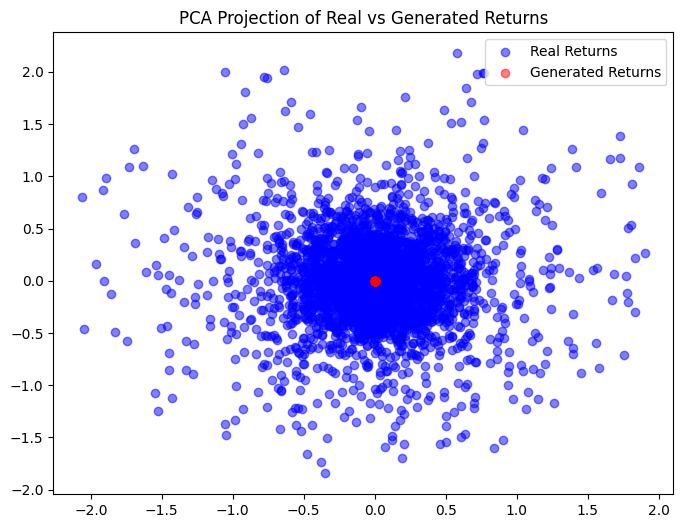

In [ ]:
pca = PCA(n_components=2)
real_pca = pca.fit_transform(np.array(windows))
gen_pca = pca.transform(generated_returns)

plt.figure(figsize=(8, 6))
plt.scatter(real_pca[:, 0], real_pca[:, 1], color="blue", label="Real Returns", alpha=0.5)
plt.scatter(gen_pca[:, 0], gen_pca[:, 1], color="red", label="Generated Returns", alpha=0.5)
plt.legend()
plt.title("PCA Projection of Real vs Generated Returns")
plt.show()

# Checking for diversity in simmulate paths

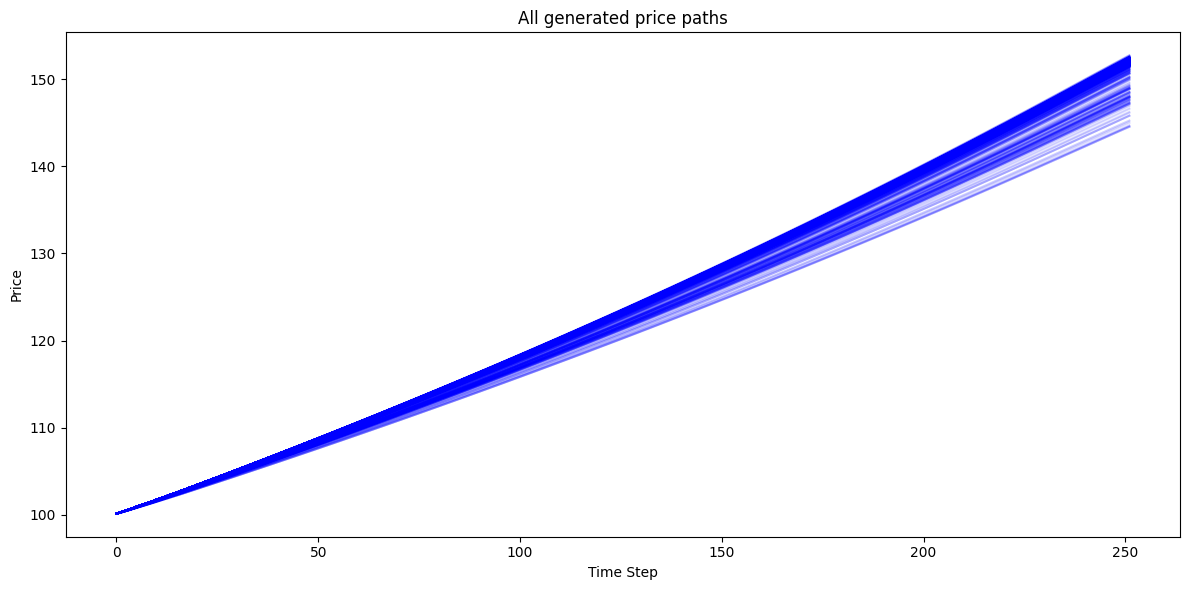

In [ ]:
initial_price = 100
price_paths = initial_price * np.cumprod(1 + generated_returns, axis=1)

plt.figure(figsize=(12, 6))
time_steps = np.arange(price_paths.shape[1])

for i in range(price_paths.shape[0]):
    plt.plot(time_steps, price_paths[i], color='blue', alpha=0.1)

plt.title("All generated price paths")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

## Checking distributions

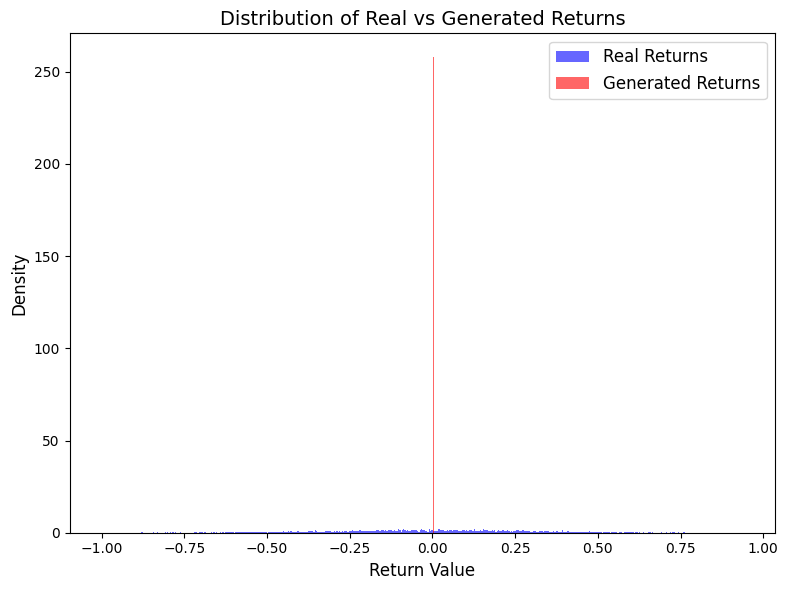

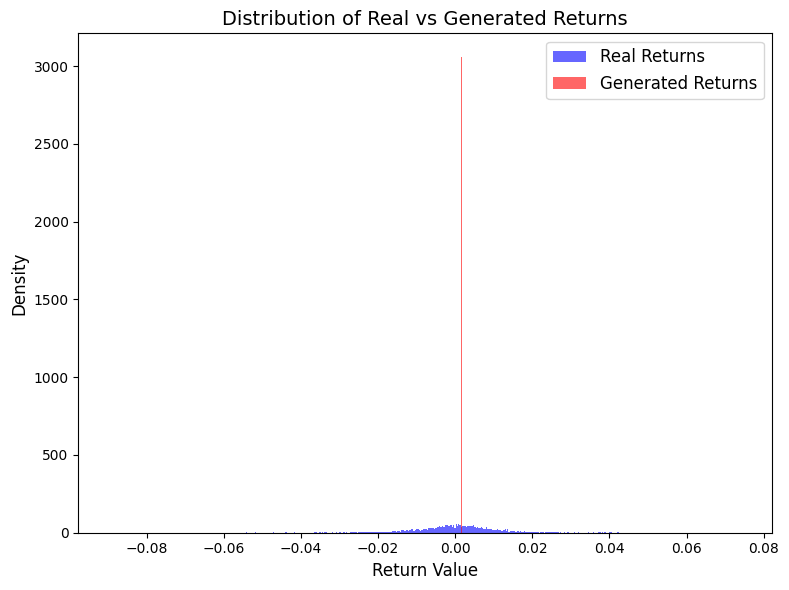

(None, None)

In [ ]:
def plot_dist(real, gen):
    real_flat = real.flatten()
    generated_flat = gen.flatten()

    plt.figure(figsize=(8, 6))

    min_val = min(np.min(real_flat), np.min(generated_flat))
    max_val = max(np.max(real_flat), np.max(generated_flat))
    bin_range = (min_val, max_val)

    plt.hist(real_flat, bins=500, alpha=0.6, color='blue', 
            density=True, range=bin_range, label='Real Returns')
    plt.hist(generated_flat, bins=500, alpha=0.6, color='red', 
            density=True, range=bin_range, label='Generated Returns')

    plt.xlabel('Return Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title('Distribution of Real vs Generated Returns', fontsize=14)
    plt.legend(fontsize=12)

    plt.grid(False)

    plt.tight_layout()
    plt.show()

plot_dist(np.array(windows), generated_returns), plot_dist(np.array(windows_real), generated_returns)

## Generating paths for non-condtional
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Generate samples and visualize
def generate_paths(n=5, path_length=252, cumsum=True):
    fakes = []
    for i in range(n):
        noise = torch.randn(1, path_length, nz, device=device)
        fake = netG(noise).detach().cpu().reshape(path_length).numpy()
        return_path = inverse(fake * returns_max, params) + returns_mean
        fakes.append(return_path)
    
    if n > 1:
        df = pd.DataFrame(fakes).T
        return df.cumsum() if cumsum else df
    else:
        path = fakes[0]
        return np.cumsum(path) if cumsum else path

# Generate and plot 5 cumulative return paths
fake_paths = generate_paths(5)
plt.figure(figsize=(12,6))
plt.plot(fake_paths, linewidth=1, alpha=0.7)
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Cumulative Returns')
plt.title('5 Generated Return Paths (252 trading days)')


def generate_fakes(n=1, seq_length=252, cumsum=True):
    fakes = []
    for i in range(n):
        noise = torch.randn(1, seq_length, nz, device=device)
        fake = netG(noise).detach().cpu().reshape(seq_length).numpy()
        fake_returns = inverse(fake * returns_max, params) + returns_mean
        fakes.append(fake_returns)
    
    if n > 1:
        if not cumsum:
            return pd.DataFrame(fakes).T
        fakes_df = pd.DataFrame(fakes).T.cumsum()
        return fakes_df
    elif not cumsum:
        return fake_returns
    return np.cumsum(fake_returns)

def compare_distributions(test_returns, horizons=[1, 5, 20, 50, 100]):
    # Create real cumulative returns
    real_cum = np.cumsum(test_returns)
    
    # Generate a fake path with same length as real data
    fake_cum = generate_fakes(seq_length=len(test_returns))
    
    # Create a dataframe with both series
    comp_df = pd.DataFrame({
        'fake': fake_cum,
        'real': real_cum
    })
    
    # Plot cumulative returns comparison
    plt.figure(figsize=(12, 6))
    comp_df.plot()
    plt.grid(True)
    plt.title('Comparison of Cumulative Returns')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.legend(['Generated', 'Real'])
    plt.show()
    
    # Plot return distributions at different horizons
    fig, axes = plt.subplots(len(horizons), 1, figsize=(12, 4*len(horizons)))
    
    for i, horizon in enumerate(horizons):
        if len(horizons) == 1:
            ax = axes
        else:
            ax = axes[i]
            
        # Calculate returns over the specified horizon
        fake_returns = comp_df['fake'].diff(horizon).dropna()
        real_returns = comp_df['real'].diff(horizon).dropna()
        
        # Plot histograms
        ax.hist([fake_returns, real_returns], bins=50, alpha=0.5, label=['fake', 'real'])
        ax.legend(loc='upper right')
        ax.set_xlabel(f'{horizon}-day Log Return')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{horizon}-day Return Distribution')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Generate multiple fake paths for comparison
    n_paths = 5
    fake_paths = generate_fakes(n=n_paths, seq_length=len(test_returns))
    
    plt.figure(figsize=(12, 6))
    for i in range(n_paths):
        plt.plot(fake_paths[i], linewidth=1, alpha=0.7, label=f'Fake {i+1}')
    plt.plot(real_cum, linewidth=2, color='black', label='Real')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.title(f'Comparison of {n_paths} Generated Paths vs Real Data')
    plt.show()
    
    return comp_df

# Run the comparison with test data
comp_df = compare_distributions(returns, horizons=[1, 5, 20, 50, 100, 252])